# Junctions Graph

__Last update: November 2022__

This notebook builds a graph of London junctions and saves the output to a dataframe. Collisions can then be mapped onto this dataset and then grouped by and ranked to identify dangerous junctions.

This approach differs from the clustering approach where we have no 'official' junctions and assume that regions of high density of collisions are where the junctions are. This approach worked well, but it has some limitations:
- With new data, different junctions are identified
- It can only spot bad junctions, not 'good' ones
- Can't generalise to handle pedestrian data

Therefore we want to first create a set of junctions and then map collisions to these. This means we can map new data as it comes in, without having to rebuild the junctions. It also means we can easily group by different periods to see what are the most dangerous junctions for that period.

In [1]:
import geopandas
import pandas as pd
import osmnx as ox
import seaborn as sns
import contextily as cx
import matplotlib.pyplot as plt

# this prevents a lot of future warnings that are coming out of oxmnx
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set(
    context='notebook',
    style='white',
    palette='Set1',
    font_scale=.9,
    font='monospace'
)

In [2]:
def convert_strings_list(x):
    '''
    Function to convert a list stored in a string to a list.
    '''
    if type(x) == int:
        return [x]
    else:
        return x.strip('][').split(', ')

## Load in example junction graph using osmnx

Using `osmnx` package, which we can read in as a networkx graph object.

The plot below shows a graph for very central London. I will expand the graph later, although it will take a while to process.

In [ ]:
# FOR FULL LONDON GRAPH - SLOW!

# G1 = ox.graph_from_place(
#     'London, UK',
#     network_type='drive',
#     simplify=True,
#     clean_periphery=True
# )

# print(f'Nodes: {len(G1.nodes)}')
# ox.plot_graph(G1);

Nodes: 648


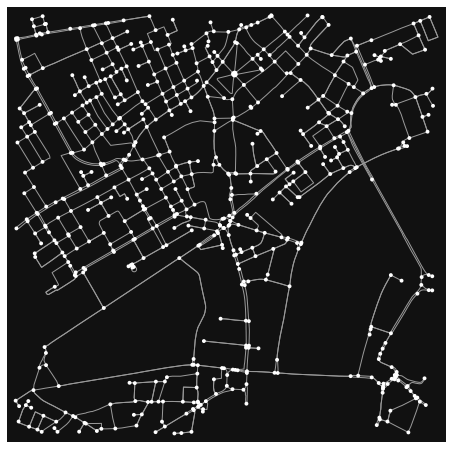

In [9]:
G1 = ox.graph_from_address(
    'London, UK',
    network_type='drive',
    dist=1000
)

print(f'Nodes: {len(G1.nodes)}')
ox.plot_graph(G1);

### Consolidate junctions

Simplify graph using the `consolidate_intersections` function. This combines junctions within a certain proximity in metres, set by the `tolerance` parameter. 25m seems to work well.

Nodes: 228


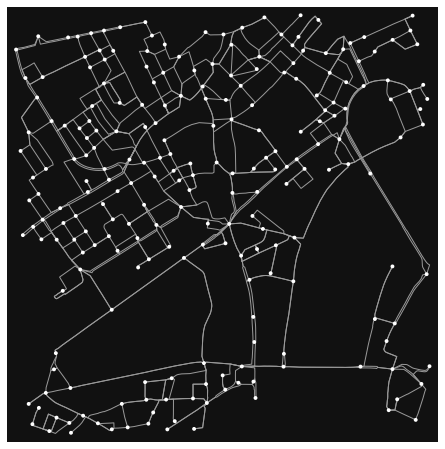

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [5]:
G2 = ox.consolidate_intersections(
    ox.project_graph(G1),
    tolerance=25,  # combines junctions within 25m
    rebuild_graph=True,
    dead_ends=False,
    reconnect_edges=True
)

print(f'Nodes: {len(G2.nodes)}')
ox.plot_graph(G2)

## Pull junction data for wider london area

This pulls a 10km square from central point.

In [6]:
G1 = ox.graph_from_address(
    'London, UK',
    network_type='drive',
    dist=10000
)

print(f'Nodes: {len(G1.nodes)}')

Nodes: 47070


## Plot the initial graph

This is far too zoomed in, but you can see there are a lot of junctions. Need to reduce this.

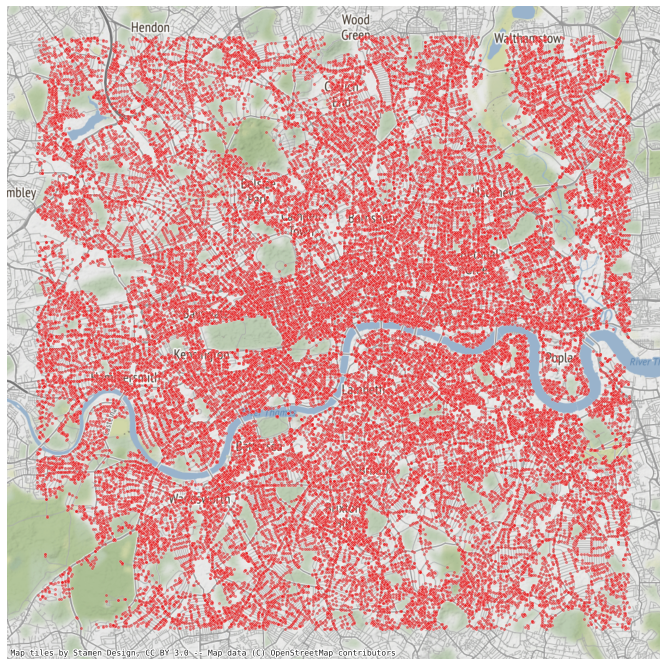

In [7]:
df_lower = ox.graph_to_gdfs(
    G1,
    nodes=True,
    edges=False,
    node_geometry=True,
    fill_edge_geometry=False
)

# rename some cols and drop some.
df_lower = (
    df_lower
    .drop(columns=['highway', 'street_count', 'ref'])
    .reset_index()
    .rename(columns={'y': 'lat', 'x': 'lon', 'osmid': 'osmid_original'})
)

df_lower.to_crs(epsg=3857,inplace=True)

fig, ax = plt.subplots(figsize=(16, 12))
sns.scatterplot(
    x=df_lower.geometry.x,
    y=df_lower.geometry.y,
    alpha=.5,
    s=10
)
sns.despine(left=True, bottom=True)
ax.set_xticks([])
ax.set_yticks([])
cx.add_basemap(ax);

## Simplify

Use `consolidate_intersections`, with tolerance = 30m.

In [14]:
G2 = ox.consolidate_intersections(
    ox.project_graph(G1),
    tolerance=35,
    rebuild_graph=True,
    dead_ends=False,
    reconnect_edges=True
)

print(f'Nodes: {len(G2.nodes)}')

Nodes: 11724


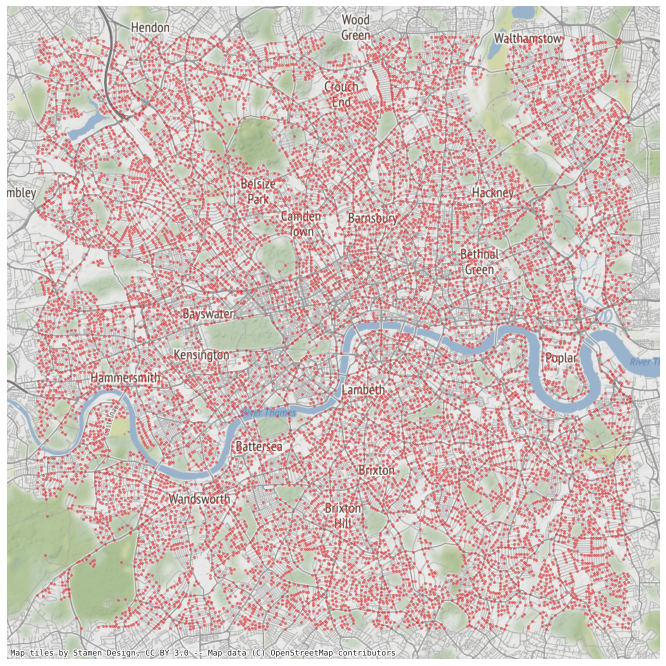

In [15]:
df_higher = ox.graph_to_gdfs(
    G2,
    nodes=True,
    edges=False,
    node_geometry=True,
    fill_edge_geometry=False
)
df_higher.to_crs(epsg=3857,inplace=True)

fig, ax = plt.subplots(figsize=(16, 12))
sns.scatterplot(
    x=df_higher.geometry.x,
    y=df_higher.geometry.y,
    alpha=.5,
    s=10
)
sns.despine(left=True, bottom=True)
ax.set_xticks([])
ax.set_yticks([])
cx.add_basemap(ax);

## Create hierarchical junction dataframe

This needs to store both the lower level junctions (before simplifying) and the higher level. This is because we want to map collisions to the lower level and then aggregate at the higher level.

For this we need to flatten the df_higher dataframe so we can join the datasets.

In [16]:
# note the nested data in `osmid_original`
display(df_higher.head())

df_higher['osmid_original'] = df_higher['osmid_original'].apply(convert_strings_list)
df_higher = df_higher.explode('osmid_original')
df_higher['osmid_original'] = df_higher['osmid_original'].astype(int)

df_higher = (
    df_higher
    .reset_index()
    .drop(columns=['x', 'y', 'street_count', 'highway', 'lon', 'lat', 'ref'])
    .rename(columns={'osmid': 'osmid_cluster'})
)

df_higher.head()

,osmid_original,x,y,street_count,lon,lat,highway,ref,geometry
osmid,,,,,,,,,
0,"[78112, 25508583, 25508584, 4595403137]",697981.452835,5.712320e+06,0,NaN,NaN,NaN,NaN,POINT (-16230.133 6715090.465)
1,"[99936, 2146383887, 4544836433, 99937, 2547079...",697573.223892,5.711872e+06,0,NaN,NaN,NaN,NaN,POINT (-16912.361 6714396.358)
2,101818,697787.069335,5.713197e+06,3,-0.148104,51.535179,NaN,NaN,POINT (-16486.840 6716512.248)
3,"[9221415718, 9221415719]",697042.283488,5.713158e+06,0,NaN,NaN,NaN,NaN,POINT (-17683.146 6716496.384)
4,"[101831, 9443627313, 905115460, 1427461955, 25...",697877.401051,5.713336e+06,0,NaN,NaN,NaN,NaN,POINT (-16333.348 6716729.904)


,osmid_cluster,osmid_original,geometry
0,0,78112,POINT (-16230.133 6715090.465)
1,0,25508583,POINT (-16230.133 6715090.465)
2,0,25508584,POINT (-16230.133 6715090.465)
3,0,4595403137,POINT (-16230.133 6715090.465)
4,1,99936,POINT (-16912.361 6714396.358)


### Merge higher and lower level junctions

Note NaNs for those juncitons that didn't get combined with any others.m

In [17]:
# combine datasets
df = df_lower.merge(
    df_higher,
    how='left',
    on='osmid_original',
    suffixes=['_original', '_cluster']
)

print('Example cluster:')
display(
    df[
        (df['osmid_original'] == 99936) |
        (df['osmid_original'] == 2146383887) |
        (df['osmid_original'] == 4544836433)
    ]
)

print('Random 5 rows:')
df.sample(5)

Example cluster:


,osmid_original,lat,lon,geometry_original,osmid_cluster,geometry_cluster
1,99936,51.523611,-0.152791,POINT (-17008.572 6714442.279),1.0,POINT (-16912.361 6714396.358)
38745,2146383887,51.523630,-0.152679,POINT (-16996.104 6714445.803),1.0,POINT (-16912.361 6714396.358)
41160,4544836433,51.524016,-0.152916,POINT (-17022.542 6714514.865),1.0,POINT (-16912.361 6714396.358)


Random 5 rows:


,osmid_original,lat,lon,geometry_original,osmid_cluster,geometry_cluster
22300,111947895,51.467353,-0.107889,POINT (-12010.182 6704383.197),7572.0,POINT (-12179.008 6704678.896)
17700,38890395,51.593480,-0.073215,POINT (-8150.212 6726952.565),9203.0,POINT (-8151.091 6726947.978)
8134,24243732,51.535208,-0.057189,POINT (-6366.239 6716517.438),249.0,POINT (-6239.210 6716950.885)
22785,119632006,51.426710,-0.114233,POINT (-12716.359 6697123.685),6226.0,POINT (-12716.359 6697123.685)
44867,7756758199,51.536158,-0.052760,POINT (-5873.172 6716687.435),249.0,POINT (-6239.210 6716950.885)


### Next, calculate lat, lons for clusters

Take the average value for this.

In [18]:
cluster_coords = (
    df
    .groupby('osmid_cluster')[['lat', 'lon']]
    .mean()
    .reset_index()
    .rename(columns={'lat': 'latitude_cluster', 'lon': 'longitude_cluster'})
)

display(cluster_coords.head())

# join in
df = df.merge(
    cluster_coords,
    how='left',
    on='osmid_cluster'
)

# fill nulls with the lower level coordinate when missing
df['latitude_cluster'] = df['latitude_cluster'].fillna(df['lat'])
df['longitude_cluster'] = df['longitude_cluster'].fillna(df['lon'])

df.head()

,osmid_cluster,latitude_cluster,longitude_cluster
0,0.0,51.527249,-0.145798
1,1.0,51.523327,-0.151831
2,2.0,51.535179,-0.148104
3,3.0,51.535090,-0.158850
4,4.0,51.536581,-0.146631


,osmid_original,lat,lon,geometry_original,osmid_cluster,geometry_cluster,latitude_cluster,longitude_cluster
0,78112,51.526976,-0.145792,POINT (-16229.536 6715044.422),0.0,POINT (-16230.133 6715090.465),51.527249,-0.145798
1,99936,51.523611,-0.152791,POINT (-17008.572 6714442.279),1.0,POINT (-16912.361 6714396.358),51.523327,-0.151831
2,99937,51.523018,-0.152024,POINT (-16923.179 6714336.201),1.0,POINT (-16912.361 6714396.358),51.523327,-0.151831
3,101818,51.535179,-0.148104,POINT (-16486.840 6716512.248),2.0,POINT (-16486.840 6716512.248),51.535179,-0.148104
4,101831,51.535612,-0.147044,POINT (-16368.841 6716589.721),4.0,POINT (-16333.348 6716729.904),51.536581,-0.146631


## Output data

This will form the input for the `mapping-collisions.ipynb` notebook.

In [19]:
df = (
    df
    .drop(
        columns=['geometry_original', 'geometry_cluster']
    )
    .reset_index()
    .rename(
        columns={
            'index': 'junction_index',
            'lat': 'latitude_junction',
            'lon': 'longitude_junction',
            'osmid_original': 'junction_id',
            'osmid_cluster': 'junction_cluster_id'
        }
    )
)

display(df.head())

df.to_csv('../data/junctions-tolerance=35.csv', index=False)

,junction_index,junction_id,latitude_junction,longitude_junction,junction_cluster_id,latitude_cluster,longitude_cluster
0,0,78112,51.526976,-0.145792,0.0,51.527249,-0.145798
1,1,99936,51.523611,-0.152791,1.0,51.523327,-0.151831
2,2,99937,51.523018,-0.152024,1.0,51.523327,-0.151831
3,3,101818,51.535179,-0.148104,2.0,51.535179,-0.148104
4,4,101831,51.535612,-0.147044,4.0,51.536581,-0.146631
